In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
data = pickle.load(open('db.pickle', 'rb'))

In [5]:
data.subreddit.value_counts()

politics                1286712
The_Donald               817118
worldnews                585547
funny                    580616
news                     580117
                         ...   
falconbms                     1
noir                          1
tubetop                       1
phgonewild                    1
Luckjes112sPortfolio          1
Name: subreddit, Length: 15696, dtype: int64

In [6]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
!python3 -m spacy download en
stop_words = stopwords.words('english')

/home/nick/anaconda3/bin/python3: No module named spacy


[nltk_data] Downloading package stopwords to /home/nick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
sub_list = ['The_Donald']

data = data[data['subreddit'].isin(sub_list)]

In [8]:
data = data[['body','controversiality','gilded','score','subreddit']]

In [9]:
len(data)

817118

In [10]:
data = data[data['score']>50]

In [11]:
len(data)

26292

In [12]:
score_df = data.sort_values(by='score',ascending = False)

In [13]:
score_df = score_df[score_df['body'] != '[deleted]']

In [14]:
score_df['body_length'] = score_df['body'].apply(lambda x: len(str(x).split(' ')))

In [15]:
score_df.head()

,body,controversiality,gilded,score,subreddit,body_length
1765548,did this idiot just issue a threat to the us,0,0,2921,The_Donald,10
3394114,#WE HAVE THE BEST FAGGOT MODERATORS DONT WE FO...,0,0,2128,The_Donald,19
745371,We've got six months to kill before the genera...,0,1,2033,The_Donald,36
2079651,"&gt; While running for US Senate, Hillary stop...",0,0,2000,The_Donald,48
4419057,I posted this in another thread but I'll post ...,0,1,1995,The_Donald,224


In [16]:
score_df = score_df[score_df['body_length'] >= 5]

In [17]:
len(score_df)

21823

In [18]:
sizifier = score_df.sample(n = 18469, random_state = 42)

In [19]:
score_df = sizifier

In [20]:
len(score_df)

18469

### Manipulation

In [21]:
score_df.head()

,body,controversiality,gilded,score,subreddit,body_length
4036313,I sure did a while ago. The situation in Europ...,0,0,80,The_Donald,117
3771746,screenname does not fit this claim,0,0,53,The_Donald,6
77153,Larry Wilcuck is a racist piece of shit and hi...,0,0,80,The_Donald,16
3057623,When she says stuff like this the Don should j...,0,0,291,The_Donald,43
543902,"He isn't even a threat, it's not like he could...",0,0,54,The_Donald,27


In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(score_df['body']))

In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [24]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [25]:
stop_words.extend(['http', 'https', 'imgur', 'com', 'jpg', 'bernie', 'hillary', 'trump', 'www', 'sander', 'sanders', 'clinton', 'donald', 'youtube', 'reddit', 'org'])

In [26]:
print(trigram[bigram[data_words[19]]])

['roger', 'stone', 'said', 'he', 'has', 'all', 'of', 'bill', 'victims', 'already', 'organized']


In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_bigrams)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['ago', 'situation', 'unchecked', 'unfettere', 'respect', 'country', 'immigrate', 'change', 'bleed', 'heart', 'liberal', 'pretty', 'quickly', 'still', 'pretty', 'liberal', 'would', 'rather', 'right', 'drank', 'coolaid', 'long', 'time', 'ago', 'take', 'long', 'time', 'realize', 'mention', 'current', 'situation', 'look', 'break', 'next', 'month', 'pretty', 'effective', 'wall', 'already', 'need', 'border']]


In [28]:
pickle.dump(data_lemmatized, open('lem_td.pickle', 'wb'))

In [29]:
data_lemmatized2 = pickle.load(open('lem_td.pickle', 'rb'))

In [30]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized2)

# Create Corpus
texts = data_lemmatized2

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1)]]


In [31]:
#Readable version:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ago', 2),
  ('already', 1),
  ('bleed', 1),
  ('border', 1),
  ('break', 1),
  ('change', 1),
  ('coolaid', 1),
  ('country', 1),
  ('current', 1),
  ('drank', 1),
  ('effective', 1),
  ('heart', 1),
  ('immigrate', 1),
  ('liberal', 2),
  ('long', 2),
  ('look', 1),
  ('mention', 1),
  ('month', 1),
  ('need', 1),
  ('next', 1),
  ('pretty', 3),
  ('quickly', 1),
  ('rather', 1),
  ('realize', 1),
  ('respect', 1),
  ('right', 1),
  ('situation', 2),
  ('still', 1),
  ('take', 1),
  ('time', 2),
  ('unchecked', 1),
  ('unfettere', 1),
  ('wall', 1),
  ('would', 1)]]

In [32]:
score_df['processed_body'] = data_lemmatized2

In [33]:
score_df.head()

,body,controversiality,gilded,score,subreddit,body_length,processed_body
4036313,I sure did a while ago. The situation in Europ...,0,0,80,The_Donald,117,"[ago, situation, unchecked, unfettere, respect..."
3771746,screenname does not fit this claim,0,0,53,The_Donald,6,[]
77153,Larry Wilcuck is a racist piece of shit and hi...,0,0,80,The_Donald,16,"[racist, deserve, cancel]"
3057623,When she says stuff like this the Don should j...,0,0,291,The_Donald,43,"[say, stuff, send, email, wedding, reception, ..."
543902,"He isn't even a threat, it's not like he could...",0,0,54,The_Donald,27,"[even, threat, could, possibly, win, important..."


In [34]:
pickle.dump(score_df, open('score_df_td.pickle', 'wb'))

In [35]:
score_df = pickle.load(open('score_df_td.pickle', 'rb'))

In [36]:
score_df.head()

,body,controversiality,gilded,score,subreddit,body_length,processed_body
4036313,I sure did a while ago. The situation in Europ...,0,0,80,The_Donald,117,"[ago, situation, unchecked, unfettere, respect..."
3771746,screenname does not fit this claim,0,0,53,The_Donald,6,[]
77153,Larry Wilcuck is a racist piece of shit and hi...,0,0,80,The_Donald,16,"[racist, deserve, cancel]"
3057623,When she says stuff like this the Don should j...,0,0,291,The_Donald,43,"[say, stuff, send, email, wedding, reception, ..."
543902,"He isn't even a threat, it's not like he could...",0,0,54,The_Donald,27,"[even, threat, could, possibly, win, important..."


### Building the Topic Model

In [37]:
from gensim import corpora, models
lda_model = models.LdaMulticore(corpus, id2word=id2word, num_topics=8, workers=7)

In [38]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -8.256547196898847


In [39]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized2, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6001671673372098


### Visualization Topics

In [40]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [41]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.008735 -0.000280       1        1  19.576432
4     -0.003865  0.007701       2        1  19.438163
1      0.002031  0.004037       3        1  12.758894
6      0.005254  0.042017       4        1  11.614749
5     -0.020529  0.012891       5        1  10.517598
7     -0.022558  0.010998       6        1   9.662494
3     -0.024170 -0.061251       7        1   9.074354
0      0.072572 -0.016113       8        1   7.357315, topic_info=        Term         Freq        Total Category  logprob  loglift
90    people  2235.000000  2235.000000  Default  30.0000  30.0000
109    woman   791.000000   791.000000  Default  29.0000  29.0000
54      know  1215.000000  1215.000000  Default  28.0000  28.0000
44       say  1908.000000  1908.000000  Default  27.0000  27.0000
58       win   460.000000   460.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
7    country    48.725836   618.677930   Topic8  -5.7282   0.0681
152      way    45.195179   533.570175   Topic8  -5.8034   0.1409
203     good    53.203727   983.922259   Topic8  -5.6403  -0.3079
29      time    51.404088   879.288546   Topic8  -5.6747  -0.2299
33     would    46.785289  1504.679085   Topic8  -5.7688  -0.8613

[679 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5204      1  0.120820  accent
5204      2  0.060410  accent
5204      3  0.120820  accent
5204      4  0.181230  accent
5204      6  0.120820  accent
...     ...       ...     ...
292       7  0.084482    year
292       8  0.052801    year
8768      1  0.843631     ƽaү
8768      4  0.099251     ƽaү
8768      5  0.049625     ƽaү

[1916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 7, 6, 8, 4, 1])

### Mallet Model

In [42]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/nick/Documents/Projects/alt-reddit/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [43]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('make', 0.07997386146576857),
   ('love', 0.03091384336986026),
   ('great', 0.03036091283804162),
   ('time', 0.029506383834321907),
   ('country', 0.025032673167789284),
   ('feel', 0.019101236553734795),
   ('life', 0.017995375490097516),
   ('long', 0.017241379310344827),
   ('live', 0.016386850306625112),
   ('kid', 0.012415803759927617)]),
 (1,
  [('woman', 0.041507610533945395),
   ('man', 0.0402995892727712),
   ('rape', 0.012176854312635902),
   ('kill', 0.012176854312635902),
   ('child', 0.011886929209954095),
   ('put', 0.010727228799226867),
   ('support', 0.009809132640734478),
   ('girl', 0.009084319884029959),
   ('muslim', 0.008697753080454215),
   ('group', 0.007731336071514858)]),
 (2,
  [('pay', 0.01971090670170828),
   ('work', 0.01939371969731297),
   ('job', 0.016312474511758577),
   ('state', 0.014318727626988083),
   ('government', 0.013095292038606189),
   ('money', 0.01164529430422765),
   ('political', 0.01150935701662966),
   ('part', 0.01064842086

In [44]:
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('make', 0.07997386146576857),
   ('love', 0.03091384336986026),
   ('great', 0.03036091283804162),
   ('time', 0.029506383834321907),
   ('country', 0.025032673167789284),
   ('feel', 0.019101236553734795),
   ('life', 0.017995375490097516),
   ('long', 0.017241379310344827),
   ('live', 0.016386850306625112),
   ('kid', 0.012415803759927617)]),
 (1,
  [('woman', 0.041507610533945395),
   ('man', 0.0402995892727712),
   ('rape', 0.012176854312635902),
   ('kill', 0.012176854312635902),
   ('child', 0.011886929209954095),
   ('put', 0.010727228799226867),
   ('support', 0.009809132640734478),
   ('girl', 0.009084319884029959),
   ('muslim', 0.008697753080454215),
   ('group', 0.007731336071514858)]),
 (2,
  [('pay', 0.01971090670170828),
   ('work', 0.01939371969731297),
   ('job', 0.016312474511758577),
   ('state', 0.014318727626988083),
   ('government', 0.013095292038606189),
   ('money', 0.01164529430422765),
   ('political', 0.01150935701662966),
   ('part', 0.01064842086

In [45]:
type(ldamallet)
# topic_df = pd.DataFrame(data=ldamallet)
# topic_df.head()

gensim.models.wrappers.ldamallet.LdaMallet

# Optimal Topics

In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [47]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

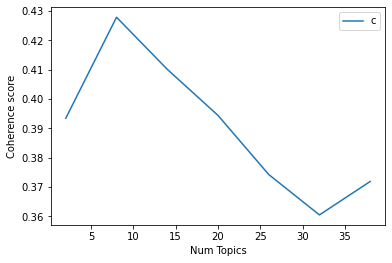

In [48]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Rerun LDA with Optimal Number of Topics

In [49]:
optimal_model = models.LdaMulticore(corpus, id2word=id2word, num_topics=8, workers=7)

In [50]:
optimal_model.print_topics(num_words=10)

[(0,
  '0.008*"time" + 0.008*"think" + 0.008*"use" + 0.007*"come" + 0.007*"make" + 0.007*"go" + 0.007*"let" + 0.007*"give" + 0.005*"would" + 0.005*"work"'),
 (1,
  '0.018*"get" + 0.016*"people" + 0.011*"see" + 0.010*"fuck" + 0.008*"think" + 0.006*"still" + 0.006*"would" + 0.006*"look" + 0.006*"make" + 0.005*"good"'),
 (2,
  '0.012*"get" + 0.011*"go" + 0.009*"think" + 0.008*"would" + 0.007*"take" + 0.007*"people" + 0.006*"even" + 0.006*"say" + 0.006*"make" + 0.006*"liberal"'),
 (3,
  '0.018*"say" + 0.011*"people" + 0.009*"would" + 0.008*"see" + 0.008*"want" + 0.007*"go" + 0.006*"look" + 0.006*"time" + 0.006*"make" + 0.005*"know"'),
 (4,
  '0.014*"people" + 0.013*"go" + 0.012*"make" + 0.011*"say" + 0.010*"would" + 0.009*"know" + 0.007*"get" + 0.007*"vote" + 0.006*"want" + 0.006*"much"'),
 (5,
  '0.014*"go" + 0.010*"people" + 0.010*"make" + 0.009*"even" + 0.008*"know" + 0.008*"right" + 0.006*"want" + 0.006*"say" + 0.006*"think" + 0.005*"fuck"'),
 (6,
  '0.014*"go" + 0.014*"say" + 0.012*"m

In [51]:
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.004313 -0.000358       1        1  20.504111
4      0.013594  0.005102       2        1  15.001330
5      0.003753  0.010645       3        1  13.559307
1     -0.003250  0.003900       4        1  13.533628
3     -0.008879 -0.028205       5        1  11.144704
0      0.034265 -0.046801       6        1   9.565991
2      0.027454  0.052966       7        1   8.720770
7     -0.071251  0.002751       8        1   7.970158, topic_info=       Term         Freq        Total Category  logprob  loglift
116     get  1678.000000  1678.000000  Default  30.0000  30.0000
44      say  1915.000000  1915.000000  Default  29.0000  29.0000
90   people  2221.000000  2221.000000  Default  28.0000  28.0000
246     use   623.000000   623.000000  Default  27.0000  27.0000
143     see  1089.000000  1089.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
113   leave    46.463781   441.846061   Topic8  -5.8557   0.2772
54     know    60.974079  1225.772914   Topic8  -5.5840  -0.4714
294     bad    45.831483   517.919956   Topic8  -5.8694   0.1046
52     even    48.450399  1069.391049   Topic8  -5.8139  -0.5648
29     time    46.472644   887.592648   Topic8  -5.8555  -0.4202

[696 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9793      5  0.796641  absence
8149      1  0.131570    abyss
8149      7  0.789417    abyss
1462      1  0.140777      act
1462      2  0.056311      act
...     ...       ...      ...
902       4  0.189580      yet
902       5  0.045499      yet
902       6  0.045499      yet
902       7  0.219912      yet
902       8  0.045499      yet

[1958 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 6, 2, 4, 1, 3, 8])

### T-SNE

In [52]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    [topic_weights.append(w for i, w in row_list)]
#     topic_weights.append(row_list[0][1])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17933 samples in 0.016s...
[t-SNE] Computed neighbors for 17933 samples in 0.500s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17933
[t-SNE] Computed conditional probabilities for sample 2000 / 17933
[t-SNE] Computed conditional probabilities for sample 3000 / 17933
[t-SNE] Computed conditional probabilities for sample 4000 / 17933
[t-SNE] Computed conditional probabilities for sample 5000 / 17933
[t-SNE] Computed conditional probabilities for sample 6000 / 17933
[t-SNE] Computed conditional probabilities for sample 7000 / 17933
[t-SNE] Computed conditional probabilities for sample 8000 / 17933
[t-SNE] Computed conditional probabilities for sample 9000 / 17933
[t-SNE] Computed conditional probabilities for sample 10000 / 17933
[t-SNE] Computed conditional probabilities for sample 11000 / 17933
[t-SNE] Computed conditional probabilities for sample 12000 / 17933
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [64]:
pickle.dump(vis, open('the_donald_vis.pickle', 'wb'))